In [9]:
# this is shamelessly stolen from Vincent Dumoulin's Github:
# https://github.com/vdumoulin/ift6266h15/blob/master/assignments/01/solution_theano.py

In [46]:
import gzip
import cPickle
import numpy
import theano
import theano.tensor as tensor
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [11]:
def one_hot_encode(y, num_classes):
    """
    Performs a one-hot encoding of a batch of integer targets
    Parameters
    ----------
    y : numpy.ndarray
        Batch of integer targets of shape (batch_size, )
    num_classes : int
        Number of classes
    Returns
    -------
    Y : numpy.ndarray
        One-hot encoded matrix of shape (batch_size, num_classes) corresponding
        to y
    """
    Y = numpy.zeros((y.shape[0], num_classes))
    for i, c in enumerate(y):
        Y[i, c] = 1
    return Y

In [12]:
# Load data
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = cPickle.load(f)
    train_X, train_y = train_set
    valid_X, valid_y = valid_set
    test_X, test_y = test_set
train_y = one_hot_encode(train_y, 10)
valid_y = one_hot_encode(valid_y, 10)
test_y = one_hot_encode(test_y, 10)

In [13]:
def relu(x):
    return tensor.switch(x>0, x, 0)

In [71]:
# Instantiate symbolic variables
X = tensor.matrix('X')
T = tensor.matrix('T')
W = theano.shared(
    numpy.random.uniform(low=-0.01, high=0.01, size=(784, 200)), 'W')
b = theano.shared(numpy.zeros(200))
V = theano.shared(
    numpy.random.uniform(low=-0.01, high=0.01, size=(200, 10)), 'V')
c = theano.shared(numpy.zeros(10))
params = [W, b, V, c]

# Build computation graph
H = tensor.nnet.sigmoid(tensor.dot(X, W) + b)
#H = relu(tensor.dot(X, W) + b)
Y = tensor.nnet.softmax(tensor.dot(H, V) + c)
loss = -(T * tensor.log(Y)).sum(axis=1).mean()
misclass = tensor.neq(T.argmax(axis=1), Y.argmax(axis=1)).mean()

grads = tensor.grad(loss, params)

In [72]:
# Compile function
updates = dict((param, param - 0.01 * grad)
               for param, grad in zip(params, grads))
f = theano.function(inputs=[X, T], updates=updates, outputs=params)
g = theano.function(inputs=[X, T], outputs=[loss, misclass])

/home/thomas/anaconda3/envs/ift6266/lib/python2.7/site-packages/ipykernel/__main__.py:4: UserWarning: The parameter 'updates' of theano.function() expects an OrderedDict, got <type 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (theano.compat.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.


In [16]:
# Call function with numerical values
batch_size = 200
num_batches = train_X.shape[0] / batch_size

params_hist = []
for epoch in xrange(10):
    for i in xrange(num_batches):
        numpy_X = train_X[batch_size * i: batch_size * (i + 1)]
        numpy_T = train_y[batch_size * i: batch_size * (i + 1)]
        params_hist.append(f(numpy_X, numpy_T))
    print "Epoch " + str(epoch + 1) + ":"
    print "    Train loss/misclass: %0.2f/%0.2f" % tuple(g(train_X, train_y))
    print "    Valid loss/misclass: %0.2f/%0.2f" % tuple(g(valid_X, valid_y))
    print "    Test  loss/misclass: %0.2f/%0.2f" % tuple(g(test_X, test_y))

Epoch 1:
    Train loss/misclass: 2.30/0.89
    Valid loss/misclass: 2.30/0.89
    Test  loss/misclass: 2.30/0.89
Epoch 2:
    Train loss/misclass: 2.30/0.89
    Valid loss/misclass: 2.30/0.89
    Test  loss/misclass: 2.30/0.89
Epoch 3:
    Train loss/misclass: 2.29/0.89
    Valid loss/misclass: 2.29/0.89
    Test  loss/misclass: 2.29/0.89
Epoch 4:
    Train loss/misclass: 2.28/0.84
    Valid loss/misclass: 2.28/0.84
    Test  loss/misclass: 2.28/0.84
Epoch 5:
    Train loss/misclass: 2.26/0.76
    Valid loss/misclass: 2.26/0.77
    Test  loss/misclass: 2.26/0.76
Epoch 6:
    Train loss/misclass: 2.23/0.70
    Valid loss/misclass: 2.23/0.69
    Test  loss/misclass: 2.23/0.69
Epoch 7:
    Train loss/misclass: 2.18/0.64
    Valid loss/misclass: 2.18/0.63
    Test  loss/misclass: 2.18/0.64
Epoch 8:
    Train loss/misclass: 2.11/0.59
    Valid loss/misclass: 2.11/0.58
    Test  loss/misclass: 2.10/0.59
Epoch 9:
    Train loss/misclass: 2.00/0.54
    Valid loss/misclass: 2.00/0.53
    Test 

In [17]:
print len(params_hist)

2500


In [18]:
print params_hist[0][0].shape
print params_hist[0][1].shape
print params_hist[0][2].shape
print params_hist[0][3].shape

(784, 200)
(200,)
(200, 10)
(10,)


In [19]:
grads_flattened = []
for i in range(len(params_hist)):
    grads = params_hist.pop()
    grads_flattened.append(np.concatenate([grad.flatten() for grad in grads]))

In [20]:
grads_flattened = np.array(grads_flattened)

In [21]:
# np.save('grads', grads_flattened)

In [22]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(grads_flattened)

PCA(copy=True, n_components=2, whiten=False)

In [27]:
mins = np.min(grads_flattened, axis=0)

In [28]:
maxs = np.max(grads_flattened, axis=0)

In [73]:
mins_transformed = pca.transform(mins)
maxs_transformed = pca.transform(maxs)
print mins_transformed, maxs_transformed

#x_min = min(mins_transformed[0][0], maxs_transformed[0][0])
#x_max = max(mins_transformed[0][0], maxs_transformed[0][0])
#y_min = min(mins_transformed[0][1], maxs_transformed[0][1])
#y_max = max(mins_transformed[0][1], maxs_transformed[0][1])
x_min = -10.
x_max = 10.
y_min = -10.
y_max = 10.

[[-0.52079406 -0.02691503]] [[-0.46404527 -0.13143617]]


/home/thomas/anaconda3/envs/ift6266/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/thomas/anaconda3/envs/ift6266/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [74]:
xx, yy = np.meshgrid(np.arange(x_min, x_max, (x_max-x_min)/20),
                     np.arange(y_min, y_max, (y_max-y_min)/20))

In [75]:
xxyy = np.c_[xx.ravel(), yy.ravel()]

In [76]:
costs = []
i = 0
for current_point in xxyy:
    print i
    i += 1
    flattened = pca.inverse_transform(current_point)
    
    W.set_value(flattened[0:784*200].reshape(784, 200))
    b.set_value(flattened[784*200:784*200+200])
    V.set_value(flattened[784*200+200:784*200+200+200*10].reshape(200, 10))
    # c.set_value(flattened[784*200+200+200*10:])
    
    costs.append(g(train_X, train_y)[0])
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [69]:
print xx.ravel().shape, yy.shape
print np.array(costs).shape

(400,) (20, 20)
(400,)


In [48]:
from mpl_toolkits.mplot3d import Axes3D


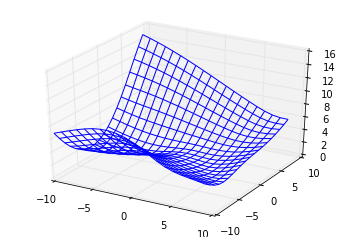

In [77]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_wireframe(xx, yy, np.array(costs).reshape(20, 20))

plt.show()

In [60]:
c = np.concatenate([xx.ravel(), yy.ravel(), np.array(costs)])
np.save('c', c)